#  Footwear Image Prediction

### By: Jun Song, Qin Che, Peiyu Li, Zimei Xu

In [1]:
import numpy as np
import pandas as pd
import urllib.request
import requests
import pydot_ng as pydot
import matplotlib.pyplot as plt
import os.path
from lxml import html
from lxml import etree
from scipy import misc
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from IPython.display import Image
from IPython.display import IFrame
from ipywidgets import interact
np.set_printoptions(precision=1)
%matplotlib inline

##  Part 1: Data Collection

###  1.  Get category information and corresponding urls

In [2]:
def get_categories(url):
    main_page = requests.get(url)
    ptree = html.fromstring(main_page.content)
    #get the div block for category information
    target_div = ptree.xpath('.//div[@id="FCTzc2Select"]')  
    
    target_content = np.array([i.text_content().split(sep='\n') for i in target_div[0]])
    #get name of categories
    target_names = target_content[:,1]
    #get the number of products in each category
    target_cnts = np.array([int(i[1:-1]) for i in target_content[:,2]])
    #get the relative url for the first page of each category
    target_urls = target_div[0].xpath('.//a/@href')
    #convert relative urls to absolute urls
    target_urls = ['http://www.6pm.com' + i for i in target_urls]
    
    return target_names, target_cnts, target_urls

def get_page_urls(url):
    c_page = requests.get(url)
    ptree = html.fromstring(c_page.content)
    #get the div block for upper page navigation
    nav_div = ptree.xpath('.//div[@class="pagination"]')
    #get the relative urls for all the pages other than the first page
    target_urls = nav_div[0].xpath('.//a/@href')
    #convert relative urls to absolute urls
    target_urls = ['http://www.6pm.com' + p for p in target_urls]
    
    return target_urls

c_names, c_cnts, c_urls = get_categories('http://www.6pm.com/women-shoes#!/shoes/CK_XAeICAQE.zso')

#use category that contains at least the given number of products, i.e. 200
c_num = len(c_cnts[c_cnts >= 200])

#get urls for the target pages that contain the needed images
urls = []
for i in range(c_num):
    p_urls = get_page_urls(c_urls[i])
    #for the category contains more than 3000 products, download the first 4 pages, otherwise the first 2 pages
    if c_cnts[i] > 3000:
        p_num = 4
    else:
        p_num = 2
    tmp = [c_urls[i]] + p_urls[:(p_num-1)]
    urls.append(tmp)

### 2.  Download images under each category and store their labels

In [3]:
labels = []
img_name = []
for c in range(c_num):
    for p in range(len(urls[c])):
        page = requests.get(urls[c][p])
        ptree = html.fromstring(page.content)
        #get the urls for target images
        image_urls = ptree.xpath('.//img[@class="productImg"]/@src')
        
        for i in range(len(image_urls)):
            tmp = c_names[c]+str(p*100+i)+'.jpg'
            #get the name of the image file
            img_name.append(tmp)
            #download image if it hasn't been downloaded yet
            if(not(os.path.isfile(tmp))):
                urllib.request.urlretrieve(image_urls[i], tmp)
            #get the category for the corresponding image
            labels.append(c_names[c])

## Part 2: Data processing 

###  1. Reshape images as standardized array format

In [4]:
#convert images into arries
pic_array = np.array([misc.imread(i,mode='RGB') for i in img_name])

#get the dimensions from the shape of the image array
rows,cols,depth=pic_array[0].shape

#flatten each pixel and RGB value
pic_array2 = []
for i in range(pic_array.shape[0]):
    pic_array2.append(pic_array[i].flatten())
np.array(pic_array2).shape

(3000, 100980)

### 2. Split training and testing dataset

In [5]:
#model training - split data
x_train, x_test, y_train, y_test = train_test_split(np.array(pic_array2), np.array(labels), test_size=.33, random_state=12)
print('The shape of the training data is: x - %s, y - %s'%(str(x_train.shape),str(y_train.shape)))
print('The shape of the test data is: x - %s, y - %s'%(str(x_test.shape),str(y_test.shape)))

The shape of the training data is: x - (2010, 100980), y - (2010,)
The shape of the test data is: x - (990, 100980), y - (990,)


## Part 3: Fit Model and Validate

## A. Classification Tree

### 1. Fit tree

In [6]:
clf_tree = tree.DecisionTreeClassifier(max_depth = 10)
clf_tree = clf_tree.fit(x_train,y_train)

### 2. Plot the tree

In [7]:
#prepare feature names
f_names = []
for i in range(rows):
    for j in range(cols):
        for k in ['R','G','B']:
            f_names.append('Pixel(x=' + str(i) + ', y=' + str(j) + '), ' + k)
    
#create .dot file
with open("tree_test.dot", 'w') as f:
    tree.export_graphviz(clf_tree, out_file=f, filled=True, label='all', feature_names=f_names, class_names=c_names[:c_num])

#convert the tree into pdf format
pydot.graph_from_dot_file('tree_test.dot').write_pdf('tree_test.pdf')

#plot the tree
print('In the tree shown below, each color represent one single category. The deeper the color is, \
the lower the gini index is, that is, the better the conditions along the branch.')
IFrame('tree_test.pdf', width=900, height=400) 

In the tree shown below, each color represent one single category. The deeper the color is, the lower the gini index is, that is, the better the conditions along the branch.


### 3. Outcome visualization - with test data

#### 3.1 Predict category

In [8]:
pred_tree_test = clf_tree.predict(x_test)

#### 3.2 Visualize the comparison between true value and prediction 

<function __main__.display_ctg>

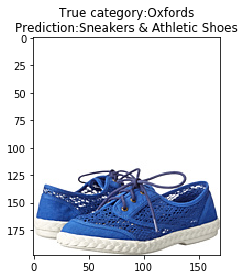

In [9]:
from ipywidgets import interact
def display_ctg(i):
    plt.imshow(x_test[i].reshape(rows,cols,depth))
    plt.gca().set_title('True category:' + str(y_test[i])+'\nPrediction:' + str(pred_tree_test[i]))
    
interact(display_ctg, i=(0,990))

### 4. Outcome validate - with test data

#### 4.1 Cross Validation Score

In [10]:
scores_tree_test = cross_val_score(clf_tree, x_test, y_test, cv=5)
print(scores_tree_test)
print('Accuracy for testing data: %.2f +/- %.2f'%(scores_tree_test.mean(),scores_tree_test.std()))

[ 0.5  0.5  0.5  0.5  0.6]
Accuracy for testing data: 0.52 +/- 0.03


####  4.2 Overall Accuracy

 build a dataframe with true category name - val, predict catetory name - predict, and if predict correctly - correct  
 accuracy = num of correct predictions / total predictions

In [11]:
df_tree_test = pd.DataFrame(data={'val':y_test, 'predict':pred_tree_test}, columns=['val', 'predict'])
df_tree_test['correct'] = (df_tree_test.val==df_tree_test.predict).astype(int)
accuracy_tree_test = sum(df_tree_test.correct)/df_tree_test.shape[0]
print('Accuracy for testing data: %.3f'%accuracy_tree_test)
df_tree_test.head()

Accuracy for testing data: 0.596


,val,predict,correct
0,Sandals,Sandals,1
1,Oxfords,Sneakers & Athletic Shoes,0
2,Boots,Boots,1
3,Oxfords,Oxfords,1
4,Heels,Clogs & Mules,0


### 5. Outcome visualization - with full data

#### 5.1 Predict category

In [12]:
pred_tree_all = clf_tree.predict(np.array(pic_array2))

#### 5.2 Visualize the comparison between true value and prediction 

<function __main__.display_shoe>

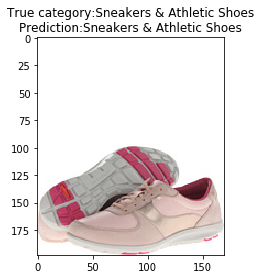

In [13]:
def display_shoe(i):
    plt.imshow(pic_array[i], interpolation='nearest')
    plt.gca().set_title('True category:' + labels[i] + '\nPrediction:' + pred_tree_all[i])

interact(display_shoe, i=(0,(pic_array.shape[0]-1)))

### 6. Outcome validate - with full data

#### 6.1 Cross Validation Score

In [14]:
scores_tree_all = cross_val_score(clf_tree, np.array(pic_array2), np.array(labels), cv=5)
print(scores_tree_all)
print('Accuracy for overall dataset: %.2f +/- %.2f'%(scores_tree_all.mean(),scores_tree_all.std()))

[ 0.5  0.5  0.6  0.5  0.6]
Accuracy for overall dataset: 0.53 +/- 0.04


#### 6.2 Overall Accuracy

 build a dataframe with true category name - val, predict catetory name - predict, and if predict correctly - correct  
 accuracy = num of correct predictions / total predictions

In [15]:
df_tree_all = pd.DataFrame(data={'val':labels, 'predict':pred_tree_all}, columns=['val', 'predict'])
df_tree_all['correct'] = (df_tree_all.val==df_tree_all.predict).astype(int)
accuracy_tree_all = sum(df_tree_all.correct)/df_tree_all.shape[0]
print('Accuracy for overall dataset: %.3f'%accuracy_tree_all)
df_tree_all.head()

Accuracy for overall dataset: 0.770


,val,predict,correct
0,Sandals,Slippers,0
1,Sandals,Sandals,1
2,Sandals,Sandals,1
3,Sandals,Sandals,1
4,Sandals,Sandals,1


## B. Support Vector Machine (SVM)

### 1. Fit SVM

In [16]:
clf_svm = svm.SVC(kernel='linear')
clf_svm = clf_svm.fit(x_train, y_train)

### 2. Outcome visualization - with test data

#### 2.1 Predict category

In [17]:
pred_svm_test = clf_svm.predict(x_test)

#### 2.2 Visualize the comparison between true value and prediction 

<function __main__.display_shoe>

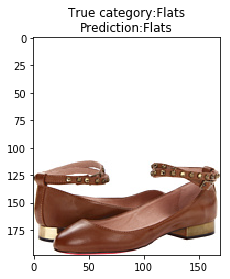

In [18]:
def display_shoe(i):
    plt.imshow(x_test[i].reshape(rows,cols,depth), interpolation='nearest')
    plt.gca().set_title('True category:' + y_test[i] + '\nPrediction:' + pred_svm_test[i])

interact(display_shoe, i=(0,(len(y_test)-1)))

### 3. Outcome validate - with test data

#### 3.1 Cross Validation Score

In [19]:
scores_svm_test = cross_val_score(clf_svm, x_test, y_test, cv=5)
print(scores_svm_test)
print('Accuracy for testing data: %.2f +/- %.2f'%(scores_svm_test.mean(),scores_svm_test.std()))

[ 0.7  0.7  0.7  0.7  0.7]
Accuracy for testing data: 0.71 +/- 0.02


#### 3.2 Overall Accuracy

 build a dataframe with true category name - val, predict catetory name - predict, and if predict correctly - correct  
 accuracy = num of correct predictions / total predictions

In [20]:
df_svm_test = pd.DataFrame(data={'val':y_test, 'predict':pred_svm_test}, columns=['val', 'predict'])
df_svm_test['correct'] = (df_svm_test.val==df_svm_test.predict).astype(int)
accuracy_svm_test = sum(df_svm_test.correct)/df_svm_test.shape[0]
print('Accuracy for testing data: %.3f'%accuracy_svm_test)
df_svm_test.head()

Accuracy for testing data: 0.738


,val,predict,correct
0,Sandals,Slippers,0
1,Oxfords,Slippers,0
2,Boots,Boots,1
3,Oxfords,Oxfords,1
4,Heels,Heels,1


### 4. Outcome visualization - with full data

#### 4.1 Predict category

In [21]:
prediction_svm_all = clf_svm.predict(np.array(pic_array2))

#### 4.2 Visualize the comparison between true value and prediction 

<function __main__.display_shoe>

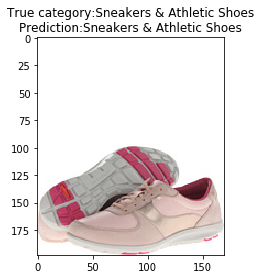

In [22]:
def display_shoe(i):
    plt.imshow(pic_array[i], interpolation='nearest')
    plt.gca().set_title('True category:' + labels[i] + '\nPrediction:' + prediction_svm_all[i])

interact(display_shoe, i=(0,(pic_array.shape[0]-1)))

### 5. Outcome validate - with full data

#### 5.1 Cross Validation Score

In [23]:
scores_svm_all = cross_val_score(clf_svm, np.array(pic_array2), np.array(labels), cv=5)
print(scores_svm_all)
print('Accuracy for overall dataset: %.2f +/- %.2f'%(scores_svm_all.mean(),scores_svm_all.std()))

[ 0.6  0.7  0.7  0.7  0.7]
Accuracy for overall dataset: 0.69 +/- 0.05


#### 5.2 Overall Accuracy

 build a dataframe with true category name - val, predict catetory name - predict, and if predict correctly - correct  
 accuracy = num of correct predictions / total predictions

In [24]:
df_svm_all = pd.DataFrame(data={'val':labels, 'predict':prediction_svm_all}, columns=['val', 'predict'])
df_svm_all['correct'] = (df_svm_all.val == df_svm_all.predict).astype(int)
accuracy_svm_all = sum(df_svm_all.correct)/df_svm_all.shape[0]
print('Accuracy for overall dataset: %.3f'%accuracy_svm_all)
df_svm_all.head()

Accuracy for overall dataset: 0.913


,val,predict,correct
0,Sandals,Slippers,0
1,Sandals,Sandals,1
2,Sandals,Sandals,1
3,Sandals,Sandals,1
4,Sandals,Sandals,1


## C. Comparison of models

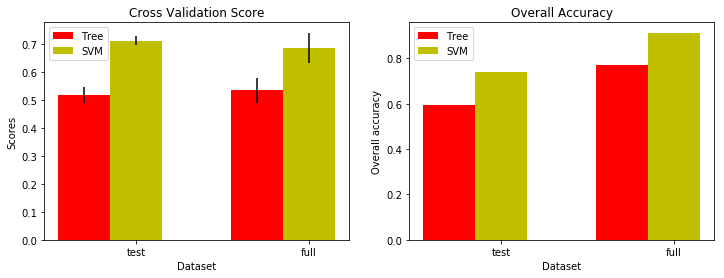

In [25]:
scores = np.array([scores_tree_test,scores_tree_all,scores_svm_test,scores_svm_all])
score_data = {'model': ['Tree']*2+['SVM']*2, 'data': ['test','full']*2, 
              'mean': scores.mean(axis=1), 'std': scores.std(axis=1)}
accuracy_data = {'model': ['Tree']*2+['SVM']*2, 'data': ['test','full']*2, 
              'accuracy': [accuracy_tree_test,accuracy_tree_all,accuracy_svm_test,accuracy_svm_all]}    
df_scores = pd.DataFrame(data=score_data,columns=['model','data','mean','std'])
df_accuracy = pd.DataFrame(data=accuracy_data,columns=['model','data','accuracy'])

# data to plot
n_groups = 2
 
# create plot
fig, axes=plt.subplots(1,2, figsize=(12,4))
index = np.arange(n_groups)
bar_width = 0.3
 
rects1 = axes[0].bar(index, df_scores['mean'][:2], bar_width,
                 color='r',
                 label='Tree',
                 yerr=df_scores['std'][:2])
 
rects2 = axes[0].bar(index + bar_width, df_scores['mean'][2:4], bar_width,
                 color='y',
                 label='SVM',
                 yerr=df_scores['std'][2:4]) 

rects3 = axes[1].bar(index, df_accuracy['accuracy'][:2], bar_width,
                 color='r',
                 label='Tree')
 
rects4 = axes[1].bar(index + bar_width, df_accuracy['accuracy'][2:4], bar_width,
                 color='y',
                 label='SVM')

for i in range(2):
    axes[i].set_xlabel('Dataset')
    axes[i].set_xticks(index + bar_width)
    axes[i].set_xticklabels(('test', 'full'))
    axes[i].legend()
axes[0].set_ylabel('Scores')
axes[1].set_ylabel('Overall accuracy')
axes[0].set_title('Cross Validation Score')
axes[1].set_title('Overall Accuracy')

## Part 4: Drilling Analysis

Group the df_svm_test by category name, and then sort by accuracy of each category in descending order.

#### 4.1 Category comparison - with test data

In [26]:
cdf_svm_test = df_svm_test[['val','correct']].groupby('val').agg(['sum','count'])
cdf_svm_test = cdf_svm_test['correct']
cdf_svm_test['accuracy'] = cdf_svm_test['sum']/cdf_svm_test['count']
cdf_svm_test = cdf_svm_test.sort_values(by='accuracy', ascending=False)
cdf_svm_test.reset_index(level=0, inplace=True)
cdf_svm_test.columns = ['category','correct number','total number','accuracy']
cdf_svm_test

,category,correct number,total number,accuracy
0,Boots,129,133,0.969925
1,Heels,102,120,0.850000
2,Flats,108,137,0.788321
3,Sneakers & Athletic Shoes,103,134,0.768657
4,Boat Shoes,51,68,0.750000
5,Clogs & Mules,46,64,0.718750
6,Slippers,41,64,0.640625
7,Oxfords,42,69,0.608696
8,Sandals,80,134,0.597015
9,Loafers,29,67,0.432836


#### 4.2 Category comparison - with full data

In [27]:
cdf_svm_all = df_svm_all[['val','correct']].groupby('val').agg(['sum','count'])
cdf_svm_all = cdf_svm_all['correct']
cdf_svm_all['accuracy'] = cdf_svm_all['sum']/cdf_svm_all['count']
cdf_svm_all = cdf_svm_all.sort_values(by='accuracy', ascending=False)
cdf_svm_all.reset_index(level=0, inplace=True)
cdf_svm_all.columns = ['category','correct number','total number','accuracy']
cdf_svm_all

,category,correct number,total number,accuracy
0,Boots,396,400,0.9900
1,Heels,382,400,0.9550
2,Flats,371,400,0.9275
3,Sneakers & Athletic Shoes,369,400,0.9225
4,Boat Shoes,183,200,0.9150
5,Clogs & Mules,182,200,0.9100
6,Slippers,177,200,0.8850
7,Oxfords,173,200,0.8650
8,Sandals,344,400,0.8600
9,Loafers,162,200,0.8100


#### 4.3 Category comparison

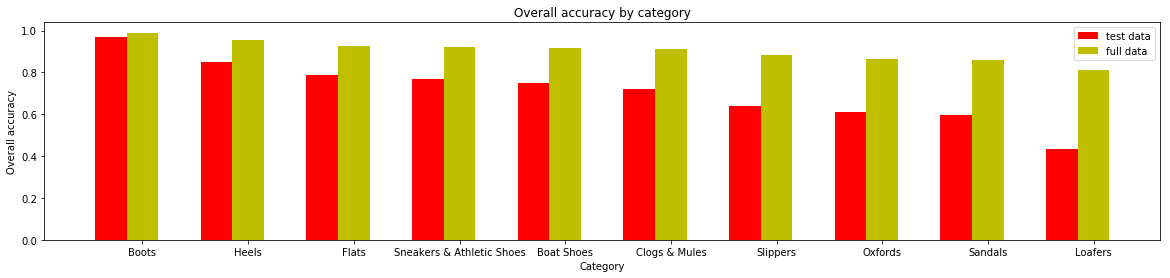

In [29]:
df = pd.merge(cdf_svm_test[['category','accuracy']],cdf_svm_all[['category','accuracy']],on='category')

# create plot
fig, ax=plt.subplots(figsize=(20,4))
index = np.arange(c_num)
bar_width = 0.3
 
rects1 = ax.bar(index, df.iloc[:,1], bar_width,
                 color='r',
                 label='test data')
 
rects2 = ax.bar(index + bar_width, df.iloc[:,2], bar_width,
                 color='y',
                 label='full data')

ax.set_xlabel('Category')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(tuple(df['category']))
ax.legend()
ax.set_ylabel('Overall accuracy')
ax.set_title('Overall accuracy by category')

## Part 5: Conclusion

Based on the cross validation score and the overall accuracy we calculated above, the SVM model predicts more accurately than classification tree with a maximum depth of 10. The result might change as we try different parameters to fit a better tree. Nonetheless, it will become less efficient for us to do this. In contrast, the SVM approach can fit a highly accurate model without lots of trials. Thereby, we choose this approach for further analysis.

Moreover, among all the categories, prediction accuracies for Boots and Heels are apparently higher than those for other categories.
One intuitive explaination for this finding is that the shapes of shoes in these two categories are easier to distinguish than those in other categories. For example, Slippers, Sandals, and Boat shoes are so similar with each other in both shape and color that we even cannot perfectly categorize them manually. No wonder the accuracies of these categories are lower.